## 初期設定

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

# データ読み込み
df = pd.read_csv("btc_jpy-1min-20250501_20251101.csv", index_col=0, parse_dates=True)

## バックテストクラス

In [ ]:
class BackTest():
  def __init__(self, df):
    self.df = df
    self.all_term = len(df)

    # numpy配列化
    self.close_array = df["close"].to_numpy()
    self.high_array = df['high'].to_numpy()
    self.low_array = df['low'].to_numpy()



  # 指定されたパラメータをもとに評価を返す関数
  def test(self, signal_term, short_term, long_term, gain_rate, loss_rate, hold_time, slippage=0.001, fee=0, levarage=1):
    # 別次元にも価格系列を拡張した2次元配列を作成する
    self.trim_term = max(long_term,hold_time)
    row = np.arange(self.trim_term)
    col = np.arange(self.all_term-self.trim_term).reshape(self.all_term-self.trim_term, 1)
    idx = row + col # 行ベクトルと列ベクトルを加算（ブロードキャストが機能する）rowは縦に複製され、colは横に複製されて加算される

    # インデックス参照を用いて2次元化する
    self.close_matrix = self.close_array[idx]
    self.high_matrix = self.high_array[idx]
    self.low_matrix = self.low_array[idx]

    # シグナル生成
    pos = self.open_signal(signal_term,short_term,long_term)

    # シミュレート
    returns = []
    position = 0
    hold = 0
    for i in range(self.trim_term,self.all_term-self.trim_term):
      if position == 0:
        if pos[i] == 1:
          position = self.close_array[i]
        elif pos[i] == -1:
          position = -self.close_array[i]
      else:
        return_ration = -2
        hold += 1
        if (position > 0 and gain_rate < self.high_array[i]/position-1) or (position < 0 and gain_rate < self.low_array[i]/position+1):
          return_ration = gain_rate
        elif (position > 0 and loss_rate > self.low_array[i]/position-1) or (position < 0 and loss_rate > self.high_array[i]/position+1):
          return_ration = loss_rate
        elif hold > hold_time:
          return_ration = self.close_array[i]/position-1 if position > 0 else 1+self.close_array[i]/position
        if return_ration != -2:
          returns.append((float(return_ration)-slippage)*(1-fee)*levarage)
          position = 0
          hold = 0

    # 評価算出
    if len(returns) == 0:
      return -1,-1,0
    returns = np.array(returns)
    sharpe_ratio = returns.mean()/returns.std()
    daily_trips = 1440/((self.all_term-self.trim_term)/len(returns))
    return sharpe_ratio.item(), returns.mean().item(), daily_trips



  # 新規注文時のシグナルを作成
  def open_signal(self, signal_term, short_term, long_term):
    # 2次元配列を元に高速でSMAを算出
    sma_signal = np.concatenate([np.zeros(self.trim_term), np.mean(self.close_matrix[:,-signal_term:], axis=1)])
    sma_short = np.concatenate([np.zeros(self.trim_term), np.mean(self.close_matrix[:,-short_term:], axis=1)])
    sma_long = np.concatenate([np.zeros(self.trim_term), np.mean(self.close_matrix[:,-long_term:], axis=1)])
    open_signal_status = np.where((sma_signal > sma_short), 1, -1)
    buy_open = np.concatenate([np.zeros(1), np.where((sma_short > sma_long)[1:] & (open_signal_status[:-1] != 1) & (open_signal_status[1:] == 1), 1, 0)])
    sell_open = np.concatenate([np.zeros(1), np.where((sma_short < sma_long)[1:] & (open_signal_status[:-1] != -1) & (open_signal_status[1:] == -1), -1, 0)])
    return (buy_open+sell_open).tolist()

backtest = BackTest(df)
print(backtest.test(30,60,120,0.03,-0.005,180,slippage=0.001))

(-0.019716217625539798, -0.00012628396165012418, 2.6003660868922833)


## グリッドサーチ

the best: -0.12362689163818616


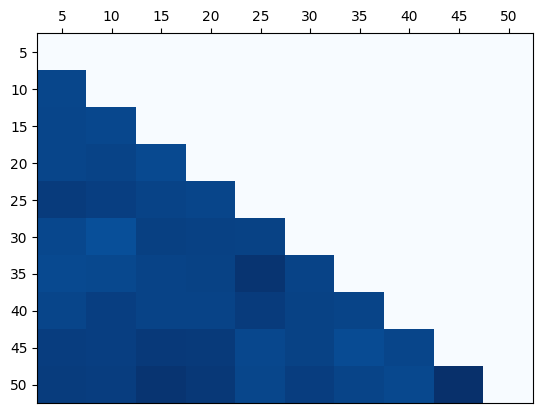

In [25]:
# 正方行列と X および Y のラベルの行列を渡す
def draw_heatmap(data, row_labels, column_labels):
    # 描画する
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues)

    ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor=False)

    ax.invert_yaxis()
    ax.xaxis.tick_top()

    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)
    plt.show()

    return heatmap

long_term = 60
gain_rate = 0.01
loss_rate = -0.01
hold_term = 120

backtest = BackTest(df)
data = np.full([10,10], -1.)
for sh_i in range(1,11):
  for si_i in range(1,sh_i):
    short_term = sh_i*5
    signal_term = si_i*5
    data[sh_i-1][si_i-1] = backtest.test(signal_term,short_term,long_term,gain_rate,loss_rate,hold_term)[0]

print("the best:",data.max())
draw_heatmap(data,[i*5 for i in range(1,11)],[i*5 for i in range(1,11)])

## ランダムサーチ

In [27]:
backtest = BackTest(df)
best_score = dict(sharp_ratio = -1, ret = -1, steps = 0, long_term = 0, short_term = 0, signal_term = 0, gain_rate = 0, loss_rate = 0, hold_term = 0)

for i in tqdm(range(1000)):
    long_term = random.choice(list(range(3,120)))
    short_term = random.choice(list(range(2,long_term)))
    signal_term = random.choice(list(range(1,short_term)))
    gain_rate = random.choice([i*0.001 for i in range(5,30)])
    loss_rate = random.choice([-i*0.001 for i in range(3,15)])
    hold_term = random.choice(list(range(60,180)))
    res = backtest.test(signal_term,short_term,long_term,gain_rate,loss_rate,hold_term)

    if best_score["sharp_ratio"] < res[0]:
      print("update_best_score:",res)
      best_score["sharp_ratio"] = res[0]
      best_score["ret"] = res[1]
      best_score["steps"] = res[2]
      best_score["long_term"] = long_term
      best_score["short_term"] = short_term
      best_score["signal_term"] = signal_term
      best_score["gain_rate"] = gain_rate
      best_score["loss_rate"] = loss_rate
      best_score["hold_term"] = hold_term

print("result",best_score)

  0%|          | 1/1000 [00:00<08:45,  1.90it/s]

update_best_score: (-0.21177766924050537, -0.0010412670012000143, 6.776540094775063)


  0%|          | 2/1000 [00:01<11:05,  1.50it/s]

update_best_score: (-0.16377054105386846, -0.0007675805409693518, 2.8719514447166583)


  1%|          | 8/1000 [00:05<10:56,  1.51it/s]

update_best_score: (-0.16360380947636496, -0.0008822924119856737, 2.918807136174892)


  1%|          | 11/1000 [00:07<11:10,  1.47it/s]

update_best_score: (-0.019604362009521568, -0.00013129893816157028, 2.8070405830765)


100%|██████████| 1000/1000 [12:10<00:00,  1.37it/s]

result {'sharp_ratio': -0.019604362009521568, 'ret': -0.00013129893816157028, 'steps': 2.8070405830765, 'long_term': 90, 'short_term': 80, 'signal_term': 48, 'gain_rate': 0.027, 'loss_rate': -0.01, 'hold_term': 165}


## ベイズ最適化